In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import linear_model#Machine learning package for a smart plot fit
from sklearn import datasets
import scipy.stats
from scipy.optimize import curve_fit
from numpy import sqrt, pi, exp, linspace, random
import seaborn as sns

In [2]:
def indexes(y,thresh,peakdist):
    dy = np.diff(y)
    ind = []
    for i in range(len(dy)):
        if len(ind) > 0:
            if dy[i] < dy[int(i-1)] and np.abs(dy[i]) > thresh and i-peakdist>ind[-1]:
                ind.append(i)
        elif len(ind) == 0: 
            if dy[i] < dy[int(i-1)] and np.abs(dy[i]) > thresh:
                ind.append(i)
    return ind  

In [5]:
df = pd.read_csv('preF.csv', delimiter=';', decimal=',',header= None)
df.columns=['Tiempo','Plato1','Plato2','Plato3','Plato4','Plato5','Plato6','Plato7','Plato8']
tiempo = []
for med in df['Tiempo']:
    tiempo.append(med*8)
df['TiempoSeg'] = tiempo
del df['Tiempo']
df.head(n=9)

,Plato1,Plato2,Plato3,Plato4,Plato5,Plato6,Plato7,Plato8,TiempoSeg
0,0.313,0.937,0.446,2.083,0.375,0.272,0.783,0.446,8
1,0.313,0.978,0.446,2.093,0.375,0.272,0.783,0.446,16
2,0.313,0.937,0.446,2.032,0.375,0.272,0.794,0.457,24
3,0.313,0.988,0.446,2.165,0.375,0.283,0.794,0.457,32
4,0.313,0.916,0.446,2.052,0.385,0.283,0.794,0.457,40
5,0.313,0.988,0.446,2.103,0.385,0.283,0.804,0.457,48
6,0.333,0.947,0.456,1.265,0.405,0.283,0.804,0.487,56
7,0.313,0.967,0.446,1.776,0.385,0.283,0.804,0.457,64
8,0.313,0.967,0.446,1.878,0.375,0.272,0.824,0.457,72


In [6]:
thresh = [0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25]# mas omenos la altura del pico
peakdist = [25,25,25,25,25,25,25,25]#la distancia entre picos
fitthreshold =[0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025] #ruido instrumental

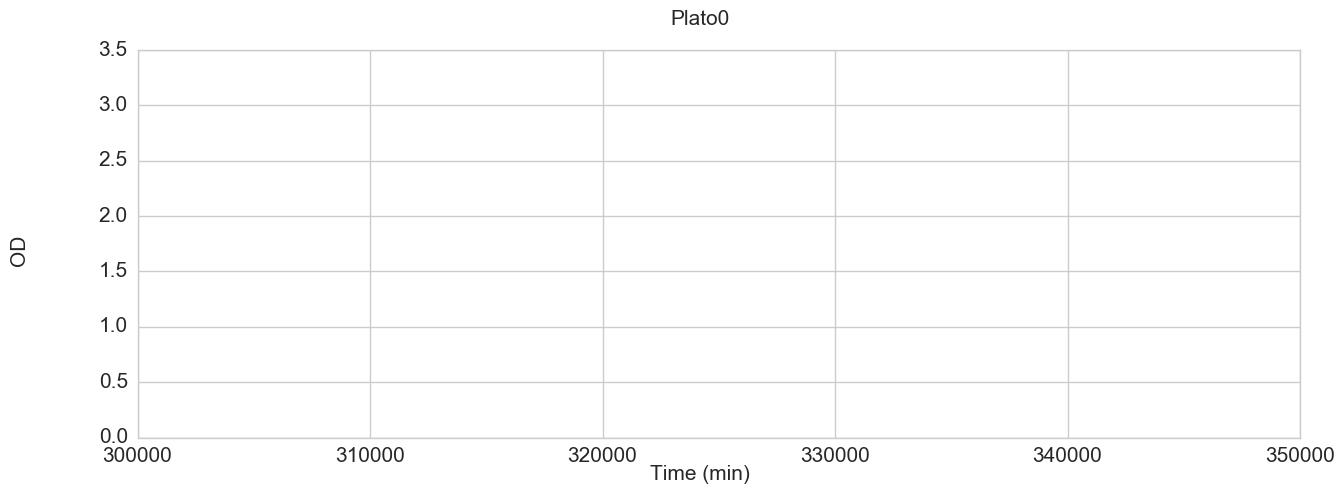

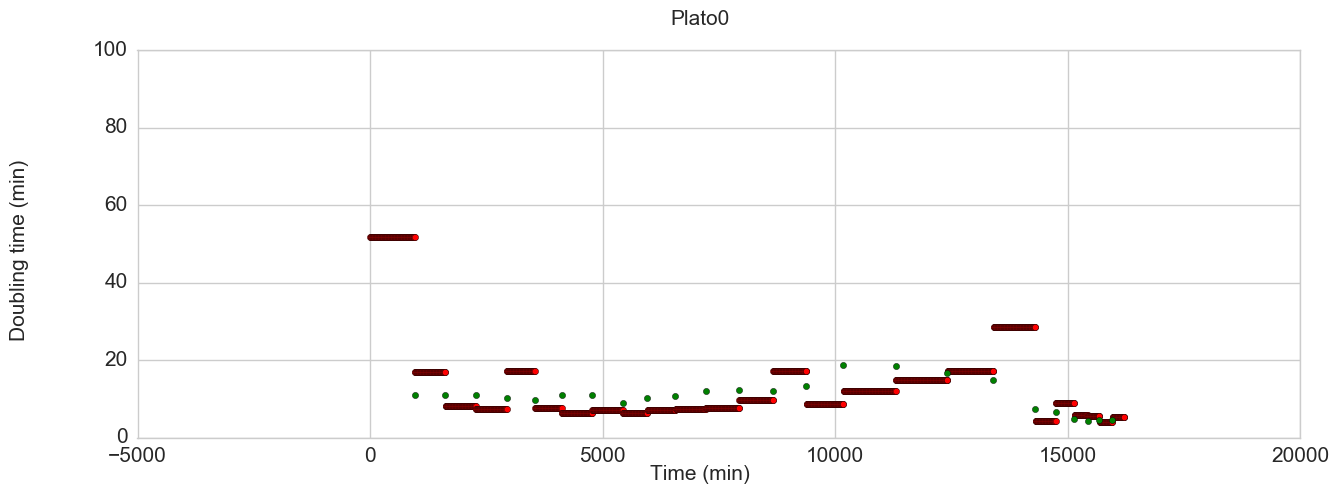

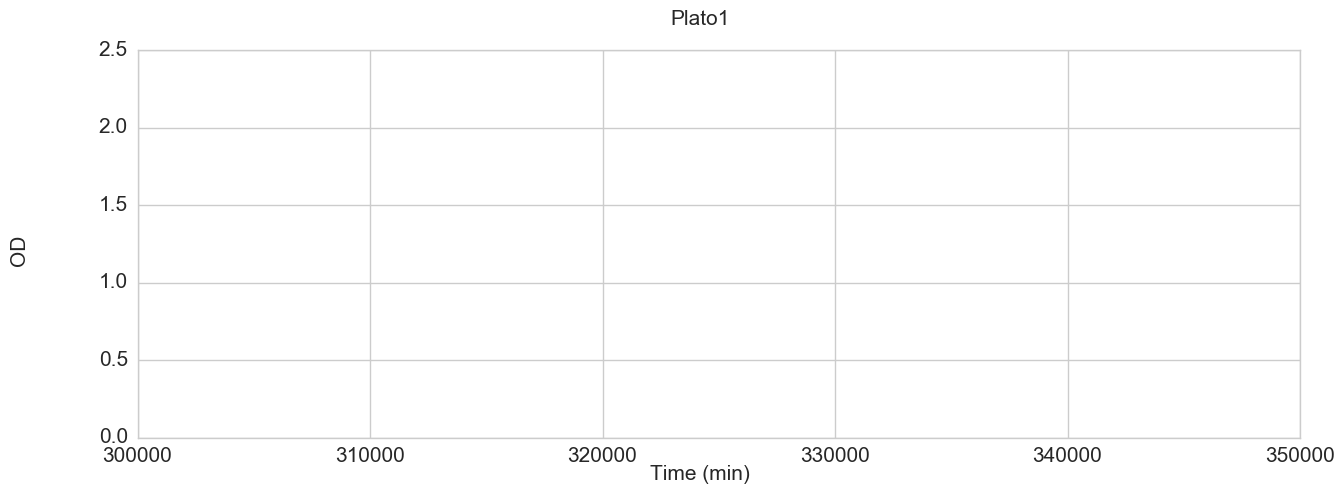

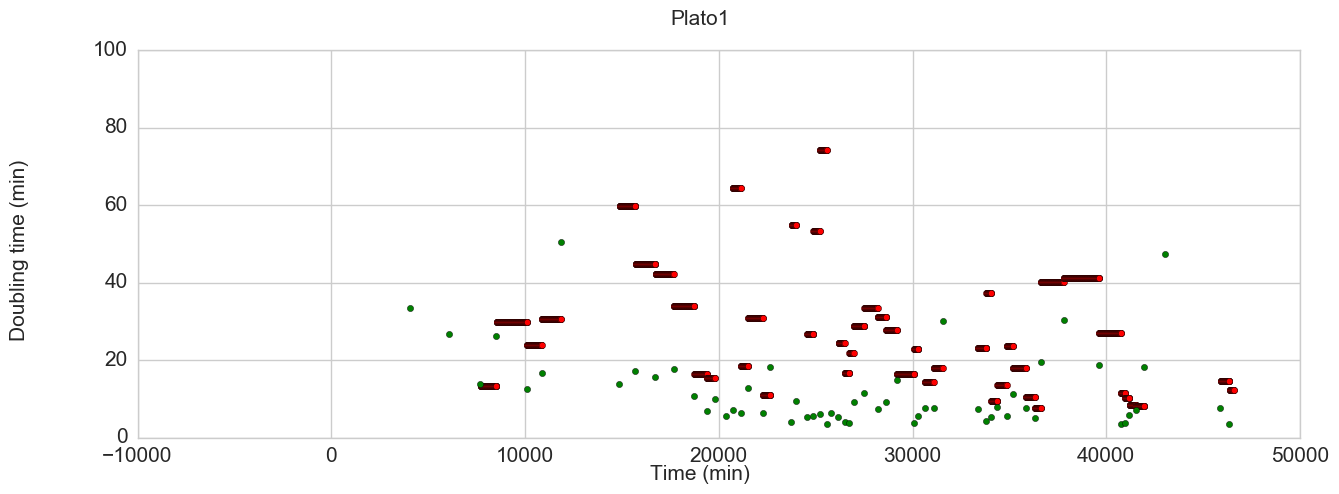

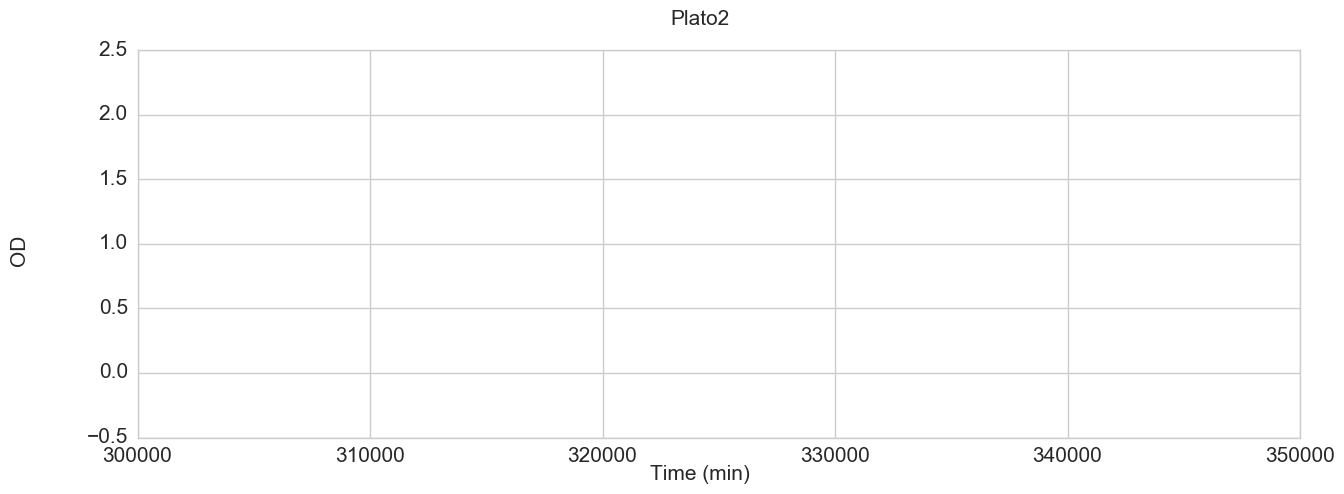

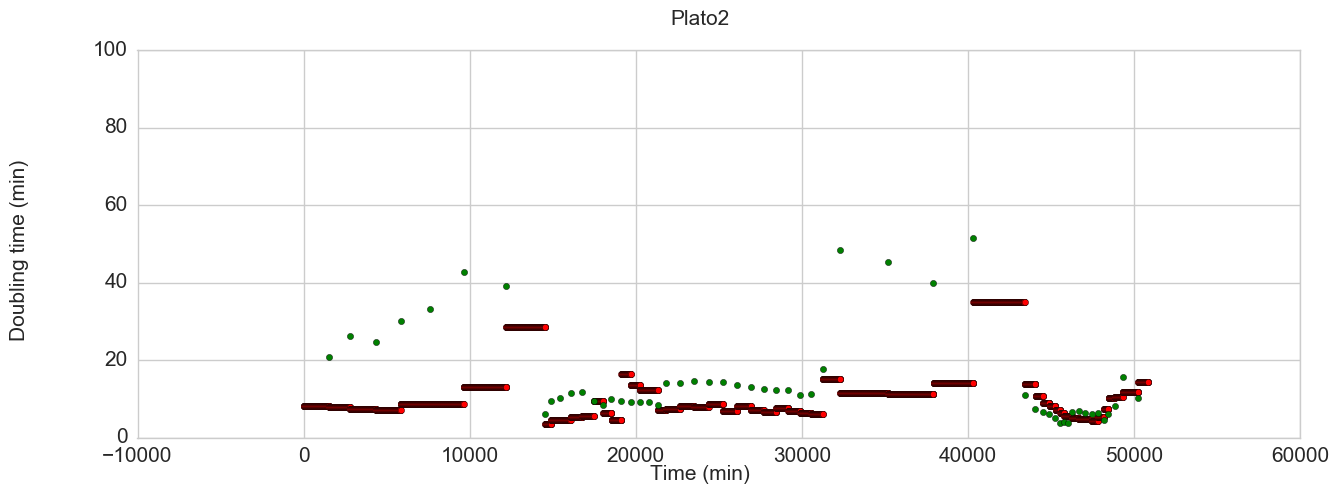

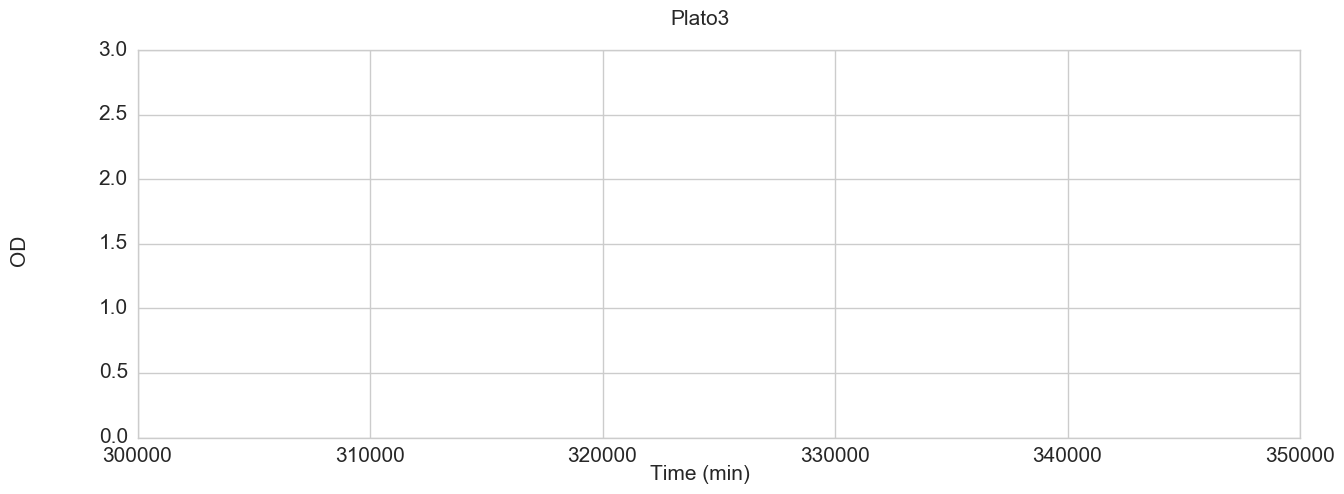

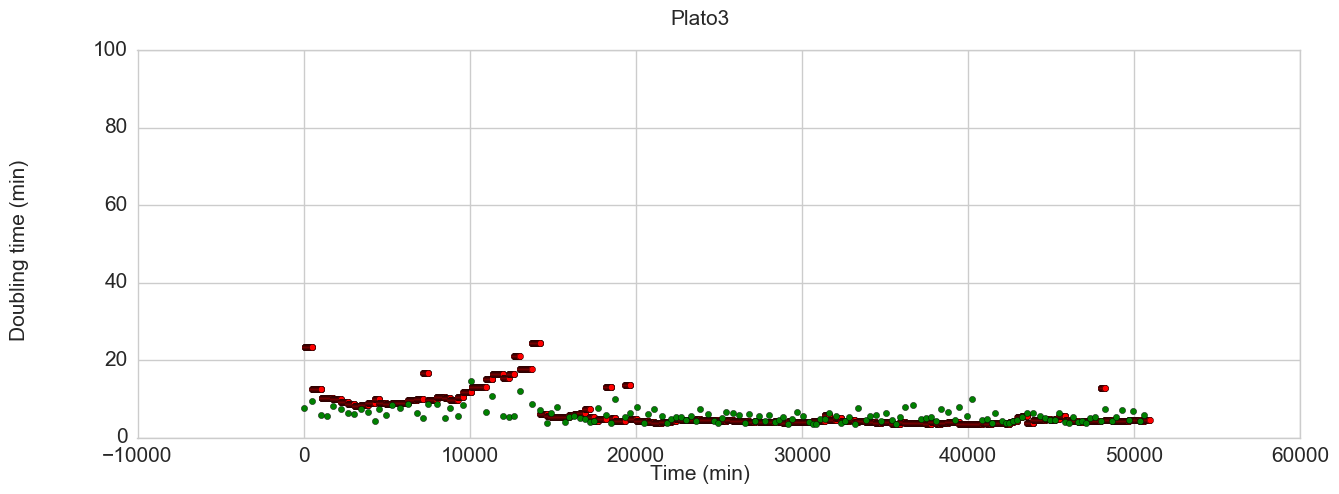

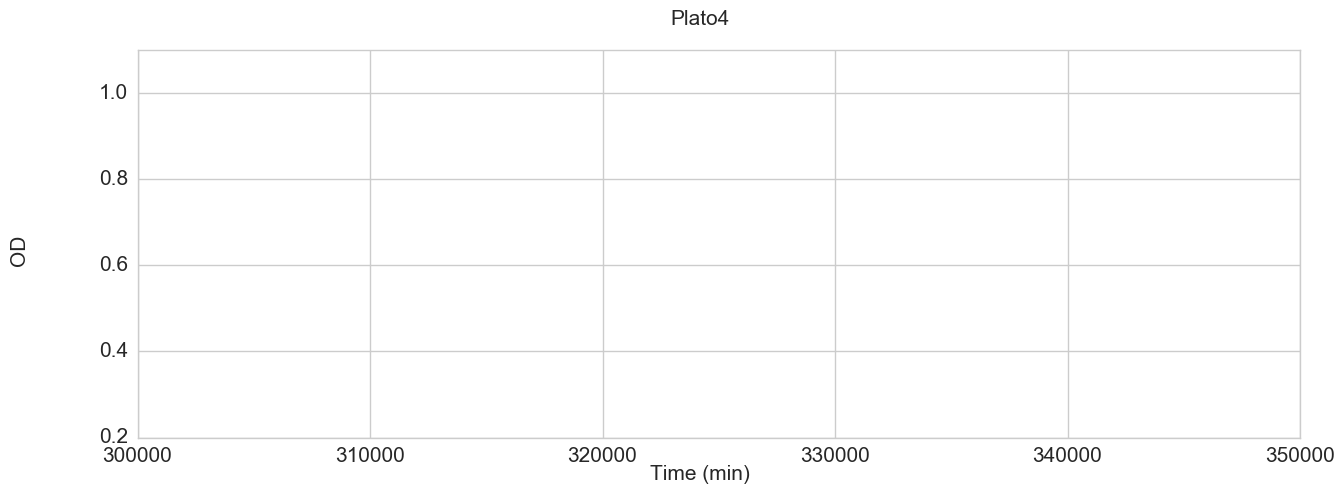

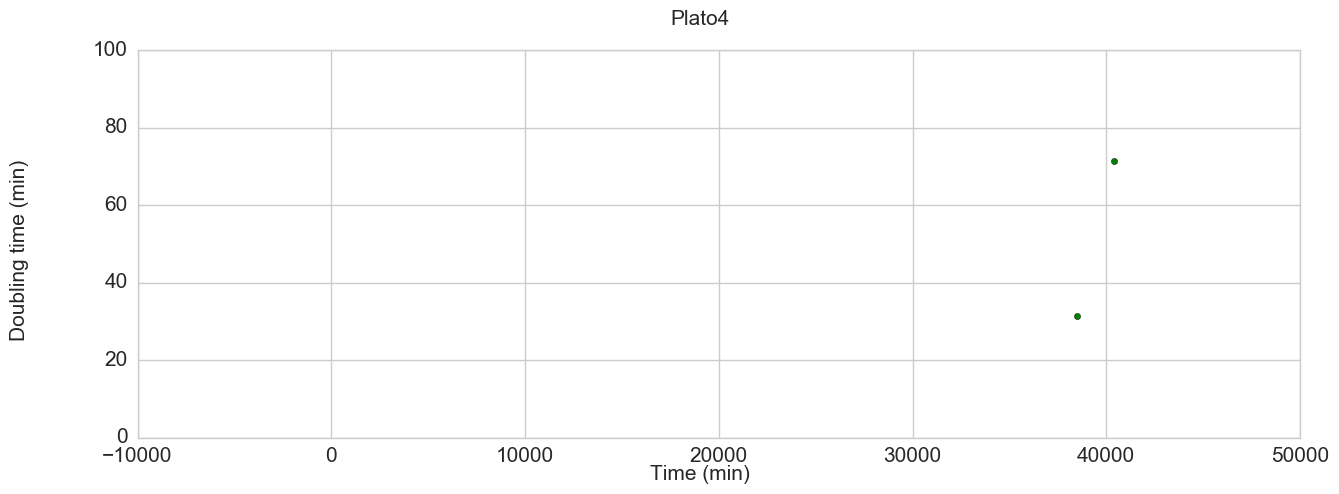

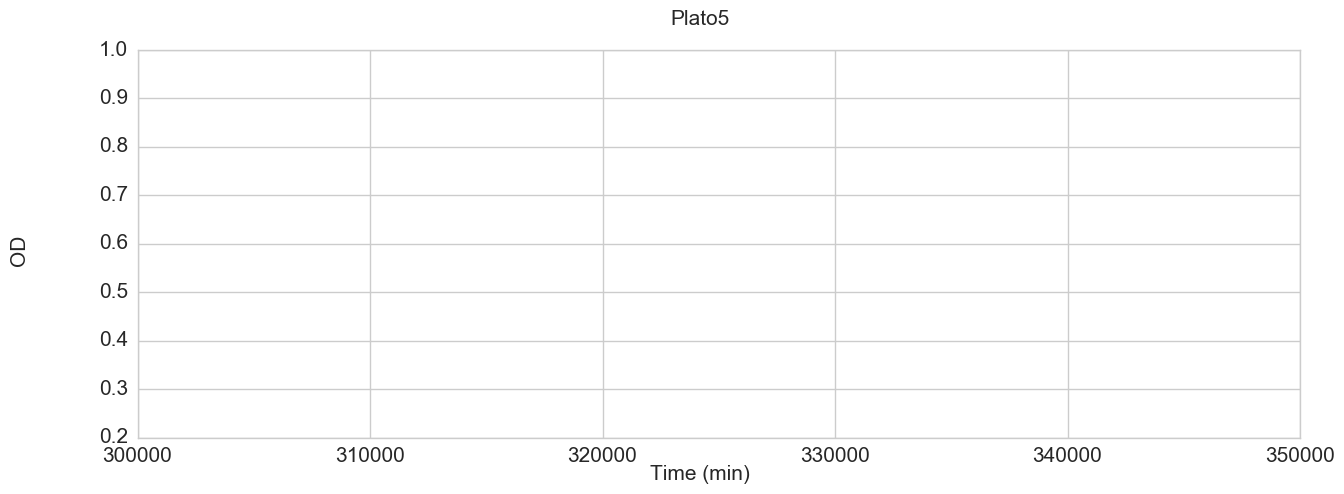

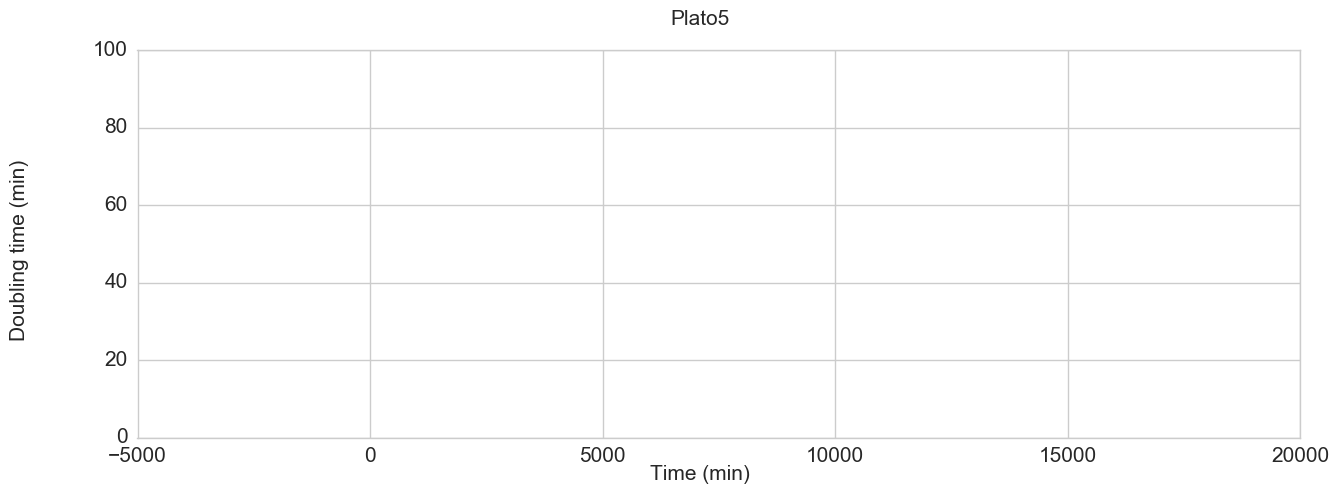

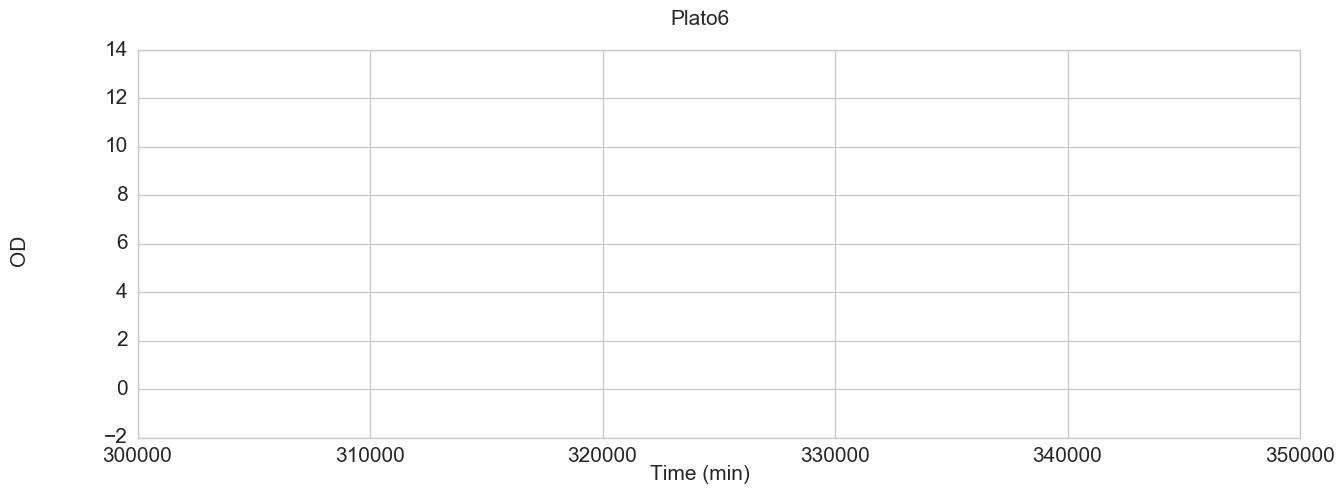

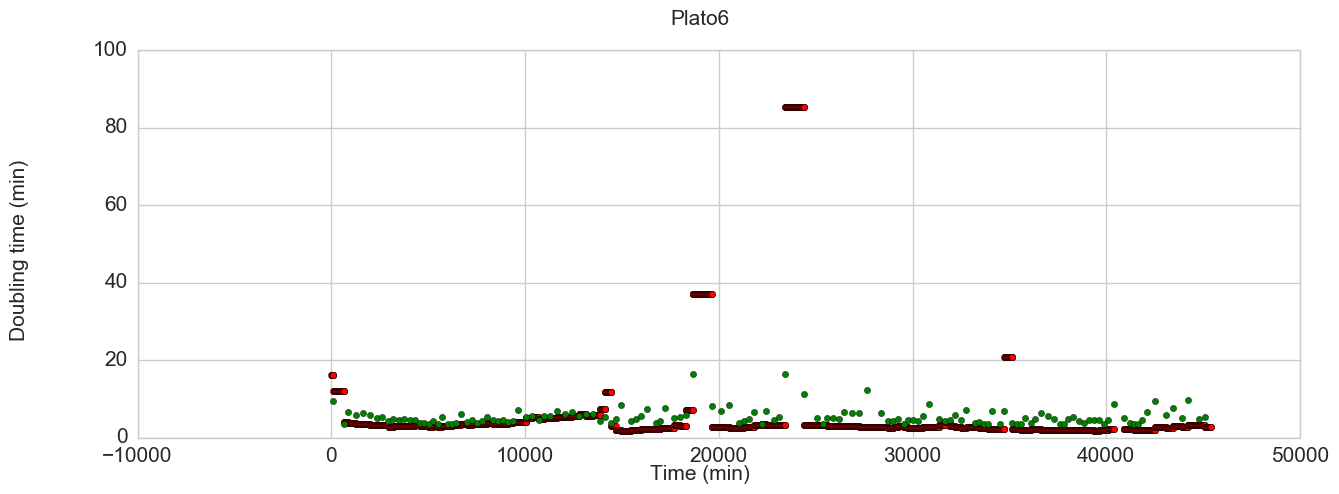

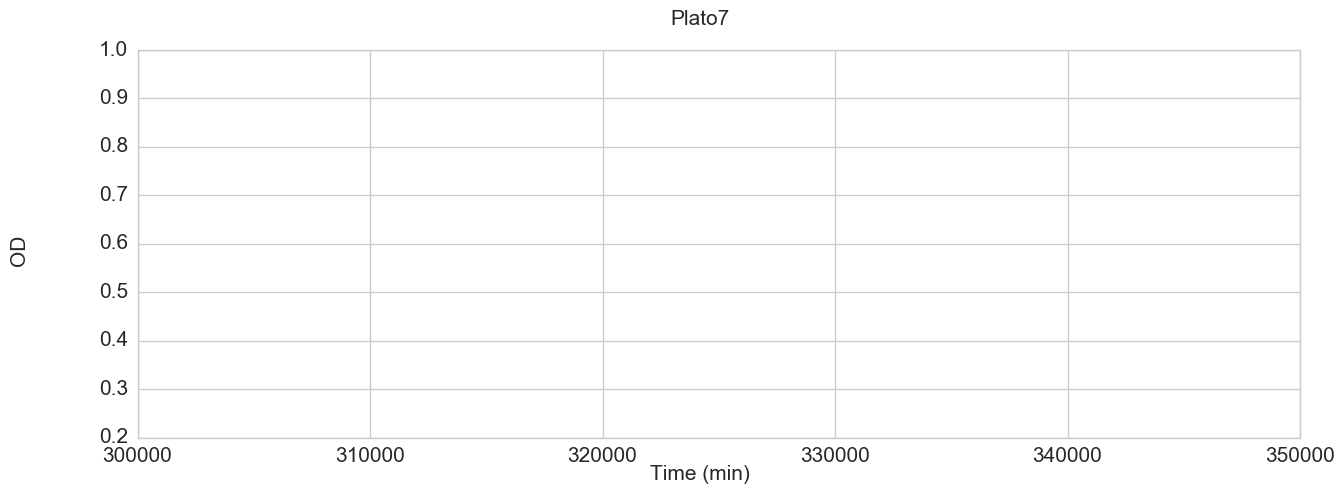

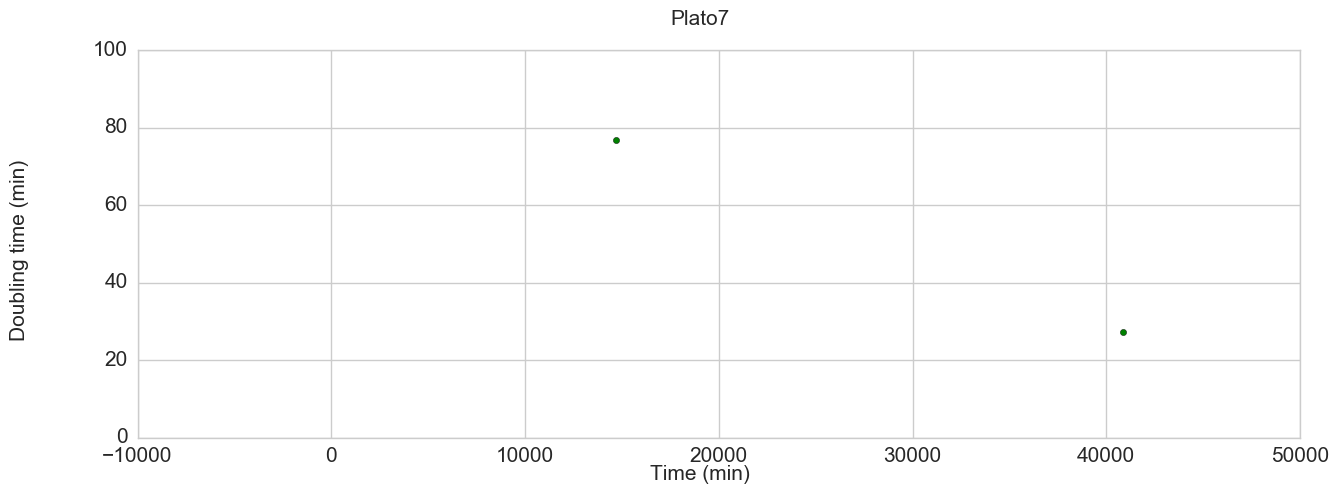

In [7]:
doublings=np.zeros((len(df), len(df.columns)-1))#number frames, #numbermothers
#fitl=np.zeros((len(df), len(df.columns)))#number frames, #numbermothers
for i in range(len(df.columns)-1):
    ind = indexes(df[df.columns[i]],thresh[i], peakdist[i])
    tind = []
    fitl=[]
    fitt=[]
    d=[]
    ln = df[df.columns[i]].tolist()
    time = df[df.columns[len(df.columns)-1]].tolist()
    lmax =[]
    lmin=[]
    tind=np.zeros(len(ind))
    for j in range(len(ind)):
        tind[j]=time[ind[j]]
        lmax.append(ln[ind[j]])
        lmin.append(ln[ind[j]+1])
        if(j>0):
            #d=float(time[ind[j]]+time[ind[j-1]])/2#division time
            tt=ind[j-1]+1#temporaltime
        else:
        #    d=float(time[ind[j]]+time[0])/2
            tt=0
        temp=0
        deltat=df['TiempoSeg'][1]-df['TiempoSeg'][0]
        dt=[]#array of log(len)
        tm=[]
        while(tt<=ind[j]):
            if(ln[tt]>0):
                logi = np.log2(ln[tt])
            else:
                logi = 0
            dt.append(logi)
            tm.append(temp)
            temp=temp + deltat
            tt=tt+1
        if(len(dt)>2):#guarantees there is enought data
            tm = np.array(tm).reshape((len(tm), 1))#converting a row into a column
            model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),residual_threshold=fitthreshold[i])#ojo con este valor
            model_ransac.fit(tm, dt)#smart fit
            a=model_ransac.estimator_.coef_
            l0=2**(model_ransac.estimator_.intercept_)
            if(j>0):
                tt=ind[j-1]+1#temporaltime
                while(tt<=ind[j]):
                    doublings[tt][i] = 1/(60*a[0])
                    d.append(1/(60*a[0]))
                    fitl.append(l0*2**((-time[ind[j-1]+1]+time[tt])*a[0]))
                    fitt.append(time[tt])
                    #d.append(1/a[0])
                    tt=tt+1   
            else:
                tt=0 
                while(tt<=ind[j]):
                    doublings[tt][i] = 1/(60*a[0])
                    d.append(1/(60*a[0]))
                    fitl.append(l0*2**(time[tt]*a[0]))
                    fitt.append(time[tt])
                    tt=tt+1
            #print(a)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5),sharex=True)
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=5, color_codes=False, rc=None)
    sns.axes_style('whitegrid')
    
    ax.set_xlim(300000,350000)#cambia el rango de observación
    
    ax.plot(time,ln,c = 'g')#,s = 20)
    ax.plot(fitt,fitl,c = 'r')
    y=[0]*len(tind)
    ax.scatter(tind,lmax, c='r', s=50 )
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    fig.suptitle('Plato' + str(i),fontsize=15)
    fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
    fig.text(0.04, 0.5, 'OD',fontsize=15, va='center', rotation='vertical')
    plt.savefig('./plato'+str(i)+'.png')
    x = np.diff(tind)
    y = range(len(x))
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 5),sharex=True)
    sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=5, color_codes=False, rc=None)
    sns.axes_style('whitegrid')    
    #ax.plot(time,ln,c = 'g')#,s = 20)
    ax.scatter(fitt,d,c = 'r',s = 20)
    ax.scatter(tind[0:-1],x/60,c='g')
    ax.set_ylim(0,100)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    #ax.set_ylim([0,15])
    fig.suptitle('Plato' + str(i),fontsize=15)
    fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
    fig.text(0.04, 0.5, 'Doubling time (min)',fontsize=15, va='center', rotation='vertical')
    plt.savefig('./growthplato'+str(i)+'.png')

In [8]:
mediangr=np.zeros(len(doublings))#len of frames
std=np.zeros(len(doublings))
for k in range(len(doublings)):#frames
    temp=[]
    for j in range (len(doublings[k])):#madres
        if(doublings[k][j] != 0.0):
            temp.append(doublings[k][j])        
    if(len(temp)>1):            
        mediangr[k]=np.median(temp)
        for l in range (len(temp)):
            stt=abs(temp[l]-mediangr[l])
            if(stt<mediangr[k]):
                std[k]+=stt/len(temp)

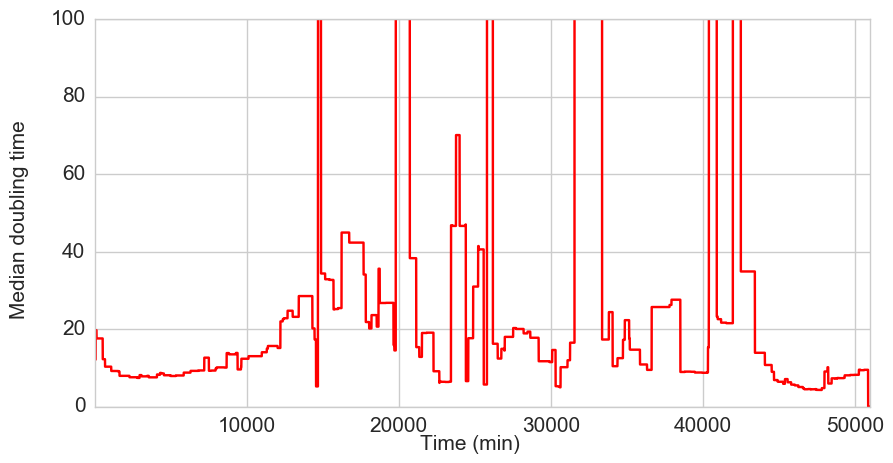

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=True)
sns.set(style='whitegrid', palette='muted', font='sans-serif', font_scale=5, color_codes=False, rc=None)
sns.axes_style('whitegrid')
ax.plot(time, mediangr, c='r')#, s=50 )
#ax.errorbar(time, mediangr, yerr=std, fmt='o',c='#006666')
ax.set_ylim([0,100])
ax.set_xlim([time[0], time[len(time)-1]])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
fig.text(0.5, 0.04, 'Time (min)',fontsize=15, ha='center')
fig.text(0.04, 0.5, 'Median doubling time',fontsize=15, va='center', rotation='vertical')
plt.savefig('mediangrowthrate.png')
f = open("./mediangrowthrate.txt", "w")#Opens and then closes the file in order to erase all previous values
f.close()
f = open("./mediangrowthrate.txt", "w")#opens the empty file 
f.write("time(min),Mediangrowtrate"+"\n")
for j in range (len(time)):
    f.write(str(time[j])+"\t"+str(mediangr[j])+"\n")
f.close()

In [10]:
f = open("alldoublings2.txt", "w")#abre y cierra en modo escritura para borrar lo que tenga adentro
f.close()
f = open("alldoublings2.txt", "w")
f.write("time\t")
for i in range(len(doublings[0])):
    f.write("plato"+str(i)+"\t")
f.write("\n")
for i in range(len(doublings)):
    f.write(str(time[i])+"\t")
    for k in range (len(doublings[i])):
        f.write(str(doublings[i][k])+"\t")
    f.write("\n")
f.close()